#### Imports

In [84]:
# Import classes from other files
from utils.dataStorage import dataStorage
from utils.model import EdgeModel

In [85]:
# Imports for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import for file handling & math
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.nn.functional import relu, binary_cross_entropy_with_logits
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv

#### Obtaining the training data

In [101]:
# Load all batches into dataset a dataStorage class
dataset = dataStorage(Path("../dataset/batch_1_" + str(9)))
for i in range(9):
    dataset.append(Path("../dataset/batch_1_" + str(i)))

# Batch dataset using DataLoader with shuffling
loader = DataLoader(dataset, batch_size=64, shuffle=True)

#### Preliminary analysis of training data

In [88]:
print("Number of graphs in set:", len(dataset))
print("Set of keys in each graph", dataset[0].keys)

Number of graphs in set: 9996
Set of keys in each graph ['edge_attr', 'x', 'y', 'edge_index']


In [89]:
print("Number of node features:", dataset[0].num_node_features)
print("Number of edge features:", dataset[0].num_edge_features)
print("Is this graph undirected? ", dataset[0].is_undirected())

Number of node features: 6
Number of edge features: 4
Is this graph undirected?  False


In [90]:
edges_average, nodes_average = 0, 0
for i in range(100):
    edges_average += dataset[i].num_edges
    nodes_average += dataset[i].num_nodes

print("Average number of nodes in first 100 graphs:", nodes_average/100)
print("Average number of edges in first 100 graphs:", edges_average/100)

Average number of nodes in first 100 graphs: 288.97
Average number of edges in first 100 graphs: 3532.54


In [91]:
percent_average = 0
for i in range(100):
    percent_average += (dataset[i]['y'].sum()/len(dataset[i]['y'])).item()

print("Proportion of edges that are True in first 100 graphs:", percent_average/100)

Proportion of edges that are True in first 100 graphs: 0.2083113230764866


We can make a few observations from these results. 

First, this dataset contains 10000 graphs with a few hundred nodes and a few thousand undirected edges. This suggests that the graphs are relatively sparse (approximately 5% of all possible edges), which could be useful information. 

Second, each node has 6 dimensions in its feature, while each edge has 4 dimensions.

Lastly, we can observe there is a class imbalance in how each edge is classified; only about 20% of edges are classified as True, while the rest are classified as False. This means that we are at risk of generating low loss values by consisently predicting values close to 0. We will try to see if we can train a model to avoid doing this.

### Initialize & Train Model

In [115]:
device = torch.device('cpu')

# Create an EdgeModel model
model = EdgeModel(dataset[0]).to(device)

# Use the Adam optimizer with learning rate 0.01, weight_decay 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [116]:
# Note: Training takes approximately 1 minute

# List to store set of loss values
loss_values = []

# Set model to begin training
model.train()
for batch in loader:
    data = batch.to(device)

    # Reset gradients to begin new training round
    optimizer.zero_grad()

    # Make a forward pass using data
    out = model(data)

    # Use BCE function to calculate loss between target data.y, out
    loss = binary_cross_entropy_with_logits(out, data.y)
    loss_values.append(loss.item())

    # Perform backpropogation using loss
    loss.backward()

    # Update all weights/biases based on gradient results
    optimizer.step()

print("Final Loss: " + str(loss_values[-1]))

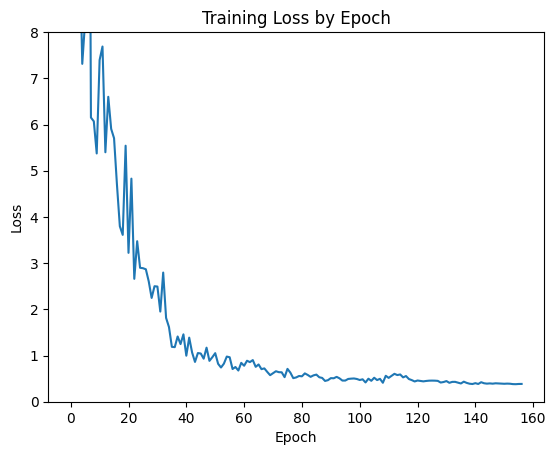

In [114]:
# Visualize loss over time
sns.lineplot(y=loss_values, x=range(len(loss_values)))

plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.ylim(0, 8)

plt.show()

#### Evaluate Model

In [ ]:
# Test whether or not 